# Exploring the evolution of lap and pole times for Silverstone, Monza and Monaco

In [583]:
#load in libraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [584]:
#Load in required data
circuits = pd.read_csv("F1_Data_raw//circuits.csv")
lap_times = pd.read_csv("F1_data_raw//lap_times.csv")
races = pd.read_csv("F1_data_raw//races.csv")
qualifying = pd.read_csv("F1_data_raw//qualifying.csv")
results = pd.read_csv("F1_data_raw//results.csv")

silverstone_poles_data = pd.read_csv("Additional_Data//silverstone_poles_data.csv")
monza_poles_data = pd.read_csv("Additional_Data//monza_poles_data.csv")
monaco_poles_data = pd.read_csv("Additional_Data//monaco_poles_data.csv")

monaco_fastest_lap_data = pd.read_csv("Additional_Data//monaco_fastest_lap_data.csv")
monza_fastest_lap_data = pd.read_csv("Additional_Data//monza_fastest_lap_data.csv")
silverstone_fastest_lap_data = pd.read_csv("Additional_Data//silverstone_fastest_lap_data.csv")


In [585]:
#find Silverstone, Monza and Monaco ID's and limit data to these tracks
circuits.circuitRef.unique()

array(['albert_park', 'sepang', 'bahrain', 'catalunya', 'istanbul',
       'monaco', 'villeneuve', 'magny_cours', 'silverstone',
       'hockenheimring', 'hungaroring', 'valencia', 'spa', 'monza',
       'marina_bay', 'fuji', 'shanghai', 'interlagos', 'indianapolis',
       'nurburgring', 'imola', 'suzuka', 'vegas', 'yas_marina', 'galvez',
       'jerez', 'estoril', 'okayama', 'adelaide', 'kyalami', 'donington',
       'rodriguez', 'phoenix', 'ricard', 'yeongam', 'jacarepagua',
       'detroit', 'brands_hatch', 'zandvoort', 'zolder', 'dijon',
       'dallas', 'long_beach', 'las_vegas', 'jarama', 'watkins_glen',
       'anderstorp', 'mosport', 'montjuic', 'nivelles', 'charade',
       'tremblant', 'essarts', 'lemans', 'reims', 'george', 'zeltweg',
       'aintree', 'boavista', 'riverside', 'avus', 'monsanto', 'sebring',
       'ain-diab', 'pescara', 'bremgarten', 'pedralbes', 'buddh',
       'americas', 'red_bull_ring', 'sochi', 'baku', 'portimao',
       'mugello', 'jeddah', 'losail', 

In [586]:
circuits[(circuits.circuitRef == "monaco") | (circuits.circuitRef == "monza") | (circuits.circuitRef == "silverstone") ]

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
5,6,monaco,Circuit de Monaco,Monte-Carlo,Monaco,43.7347,7.42056,7,http://en.wikipedia.org/wiki/Circuit_de_Monaco
8,9,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,153,http://en.wikipedia.org/wiki/Silverstone_Circuit
13,14,monza,Autodromo Nazionale di Monza,Monza,Italy,45.6156,9.28111,162,http://en.wikipedia.org/wiki/Autodromo_Naziona...


Now we know that Monaco has circuit id of 6, Monza is 14 and Silverstone is 9.

Next we limit the races database to just those at these tracks.

In [587]:
#Limiting races to these tracks
races_limited = races[(races.circuitId.isin([6,9,14]))]

#Drop down races_limited to just the columns we need
races_limited = races_limited[["raceId", "year", "circuitId", "name"]]
races_limited.describe()



,raceId,year,circuitId
count,200.00000,200.000000,200.000000
mean,554.49000,1988.595000,9.790000
std,310.17638,21.232169,3.415292
min,6.00000,1950.000000,6.000000
25%,284.00000,1970.750000,6.000000
50%,586.50000,1990.000000,9.000000
75%,799.25000,2007.000000,14.000000
max,1112.00000,2023.000000,14.000000


Next up we are going to look at the qualifying times and limit just to the races outlined above

In [588]:
#Inspect layout of qualifying dataframe
print(qualifying.head())
print(qualifying.dtypes)
print(qualifying.describe())


   qualifyId  raceId  driverId  constructorId  number  position        q1  \
0          1      18         1              1      22         1  1:26.572   
1          2      18         9              2       4         2  1:26.103   
2          3      18         5              1      23         3  1:25.664   
3          4      18        13              6       2         4  1:25.994   
4          5      18         2              2       3         5  1:25.960   

         q2        q3  
0  1:25.187  1:26.714  
1  1:25.315  1:26.869  
2  1:25.452  1:27.079  
3  1:25.691  1:27.178  
4  1:25.518  1:27.236  
qualifyId         int64
raceId            int64
driverId          int64
constructorId     int64
number            int64
position          int64
q1               object
q2               object
q3               object
dtype: object
         qualifyId       raceId     driverId  constructorId       number  \
count  9815.000000  9815.000000  9815.000000    9815.000000  9815.000000   
mean   4920

In [589]:
#Converting q3 to a time in seconds and making column float
q3_split = qualifying.q3.str.split(":")
qualifying["q3min"] = q3_split.str.get(0)
qualifying["q3sec"] = q3_split.str.get(1)
qualifying["q3min"] = qualifying["q3min"].astype("float")
qualifying["q3sec"] = qualifying["q3sec"].astype("float")
qualifying["q3"] = 60*qualifying["q3min"] + qualifying["q3sec"]

q1_split = qualifying.q1.str.split(":")
qualifying["q1min"] = q1_split.str.get(0)
qualifying["q1sec"] = q1_split.str.get(1)
qualifying["q1min"] = qualifying["q1min"].astype("float")
qualifying["q1sec"] = qualifying["q1sec"].astype("float")
qualifying["q1"] = 60*qualifying["q1min"] + qualifying["q1sec"]



#Droping qualifying down to required columns
qualifying = qualifying[["qualifyId", "raceId", "driverId", "constructorId", "q1", "q3", "position"]]
qualifying.head()



,qualifyId,raceId,driverId,constructorId,q1,q3,position
0,1,18,1,1,86.572,86.714,1
1,2,18,9,2,86.103,86.869,2
2,3,18,5,1,85.664,87.079,3
3,4,18,13,6,85.994,87.178,4
4,5,18,2,2,85.960,87.236,5


In [590]:
#To find pole times, we limit to position = 1
qualifying_poles = qualifying[qualifying.position == 1]

#remove position column
qualifying_poles = qualifying_poles[["qualifyId", "raceId", "driverId", "constructorId", "q1", "q3"]]
print(qualifying_poles.head(30))
print(qualifying_poles.shape)

     qualifyId  raceId  driverId  constructorId       q1       q3
0            1      18         1              1   86.572   86.714
22          23      19        13              6   95.347   95.748
44          45      20         9              2   92.893   93.096
66          67      21         8              6   80.701   81.813
88          89      22        13              6   85.994   87.617
108        109      23        13              6   75.190   75.787
128        129      24         1              1   76.909   77.886
148        149      25         8              6   75.133   76.449
168        169      26         5              1   79.957   81.049
188        189      27         1              1   75.218   75.666
208        209      28         1              1   79.376   80.899
228        229      29        13              6   98.176   98.989
248        249      30         1              1  106.887  107.338
268        269      31        20              5   95.464   97.555
288       

In [591]:
#Drop down to Monaco, Monza and Silverstone
merged_df = qualifying_poles.merge(races_limited, how = "inner", on = "raceId")


#Create new pole time column, we want to assign it the q3 value if non null, otherwise we take q1, this is due to a change in qualifying formats
merged_df["pole_time"] = merged_df["q1"]

for i in range(len(merged_df)):
    entry = merged_df.iloc[i][5]
    if np.all(pd.notnull([entry])):
        merged_df.iat[i,9] = entry
    

In [592]:
#Rename merged_df and drop down to required columns
qualifying_pole_times = merged_df[["year", "circuitId", "name", "pole_time"]]

#Sort by year
qualifying_pole_times=qualifying_pole_times.sort_values(by=['year'])



#Split into Monaco, Silvestone and Monza
monaco_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 6]
monza_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 14]
silverstone_qualifying_pole_times = qualifying_pole_times[qualifying_pole_times.circuitId == 9]



In [593]:
print(monza_qualifying_pole_times)

    year  circuitId                name  pole_time
21  1994         14  Italian Grand Prix     83.844
19  1995         14  Italian Grand Prix     84.462
30  2003         14  Italian Grand Prix     80.963
11  2004         14  Italian Grand Prix     80.089
10  2005         14  Italian Grand Prix     80.878
8   2006         14  Italian Grand Prix     81.484
5   2007         14  Italian Grand Prix     81.997
2   2008         14  Italian Grand Prix     97.555
24  2009         14  Italian Grand Prix     84.066
27  2010         14  Italian Grand Prix     81.962
42  2011         14  Italian Grand Prix     82.275
38  2012         14  Italian Grand Prix     84.010
41  2013         14  Italian Grand Prix     83.755
45  2014         14  Italian Grand Prix     84.109
48  2015         14  Italian Grand Prix     83.397
51  2016         14  Italian Grand Prix     81.135
54  2017         14  Italian Grand Prix     95.554
57  2018         14  Italian Grand Prix     79.119
60  2019         14  Italian Gr

# Exploring pole times plots

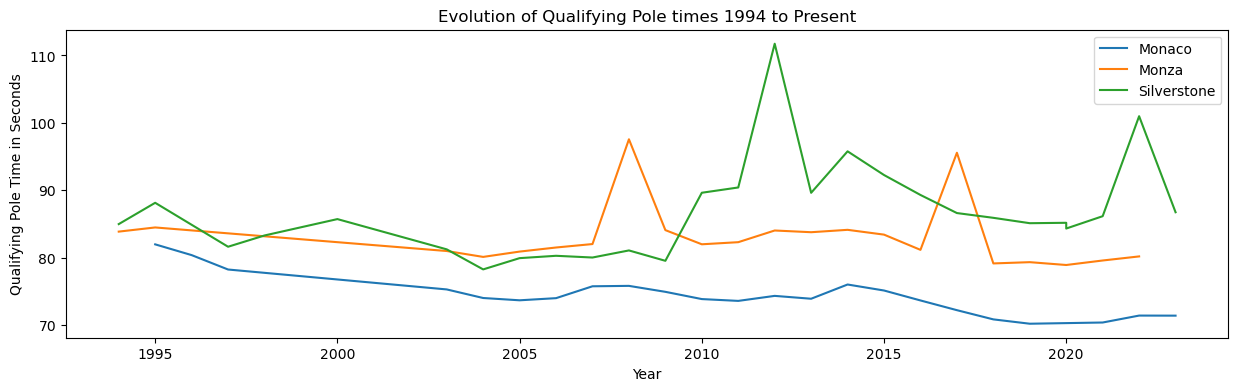

<Figure size 640x480 with 0 Axes>

In [594]:
plt.figure(figsize = (15,4))
plt.plot(monaco_qualifying_pole_times.year,monaco_qualifying_pole_times.pole_time, label = "Monaco")
plt.plot(monza_qualifying_pole_times.year,monza_qualifying_pole_times.pole_time, label = "Monza")
plt.plot(silverstone_qualifying_pole_times.year,silverstone_qualifying_pole_times.pole_time, label = "Silverstone")

plt.legend()
plt.title("Evolution of Qualifying Pole times 1994 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()
plt.clf()

In [595]:
silverstone_poles_data_split = silverstone_poles_data['pole_time'].str.split(":")
silverstone_poles_data["mins"] = silverstone_poles_data_split.str.get(0)
silverstone_poles_data["secs"] = silverstone_poles_data_split.str.get(1)
silverstone_poles_data["mins"] = silverstone_poles_data["mins"].astype("float")
silverstone_poles_data["secs"] = silverstone_poles_data["secs"].astype("float")
silverstone_poles_data["pole_time"] = 60*silverstone_poles_data["mins"] + silverstone_poles_data["secs"]
silverstone_poles_data = silverstone_poles_data[["year", "driver", "pole_time"]]
print(silverstone_poles_data.head())


   year                       driver  pole_time
0  1950        (ITA) Giuseppe Farina      110.8
1  1951  (ARG) Jose Froilan Gonzalez      103.4
2  1952        (ITA) Giuseppe Farina      110.0
3  1953         (ITA) Alberto Ascari      108.0
4  1954     (ARG) Juan Manuel Fangio      105.0


In [596]:
monza_poles_data_split = monza_poles_data['pole_time'].str.split(":")
monza_poles_data["mins"] = monza_poles_data_split.str.get(0)
monza_poles_data["secs"] = monza_poles_data_split.str.get(1)
monza_poles_data["mins"] = monza_poles_data["mins"].astype("float")
monza_poles_data["secs"] = monza_poles_data["secs"].astype("float")
monza_poles_data["pole_time"] = 60*monza_poles_data["mins"] + monza_poles_data["secs"]
monza_poles_data = monza_poles_data[["year", "driver", "pole_time"]]

In [597]:
monaco_poles_data_split = monaco_poles_data['pole_time'].str.split(":")
monaco_poles_data["mins"] = monaco_poles_data_split.str.get(0)
monaco_poles_data["secs"] = monaco_poles_data_split.str.get(1)
monaco_poles_data["mins"] = monaco_poles_data["mins"].astype("float")
monaco_poles_data["secs"] = monaco_poles_data["secs"].astype("float")
monaco_poles_data["pole_time"] = 60*monaco_poles_data["mins"] + monaco_poles_data["secs"]
monaco_poles_data = monaco_poles_data[["year", "driver", "pole_time"]]

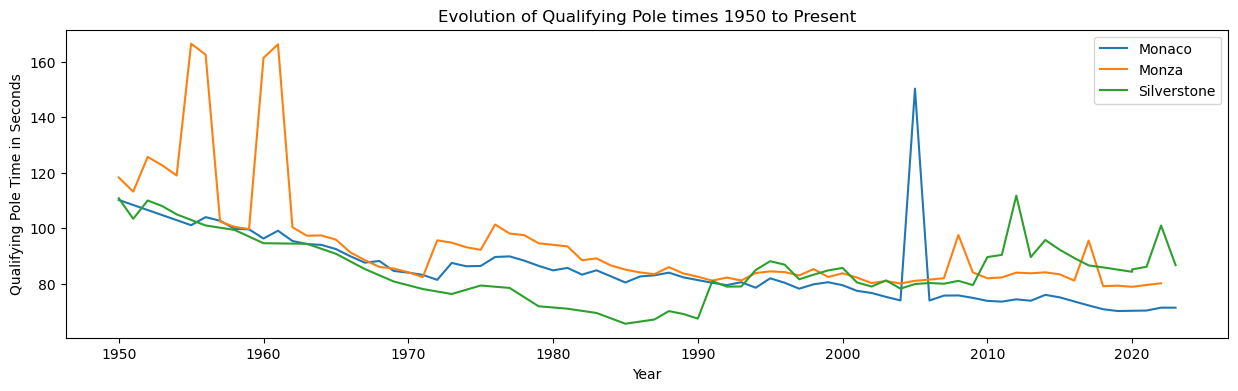

<Figure size 640x480 with 0 Axes>

In [598]:
plt.figure(figsize = (15,4))
plt.plot(monaco_poles_data.year,monaco_poles_data.pole_time, label = "Monaco")
plt.plot(monza_poles_data.year,monza_poles_data.pole_time, label = "Monza")
plt.plot(silverstone_poles_data.year,silverstone_poles_data.pole_time, label = "Silverstone")

plt.legend()
plt.title("Evolution of Qualifying Pole times 1950 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()
plt.clf()

# Fastest lap speeds

In [599]:
#Changing fastest lap speed to float
results.fastestLapSpeed = results.fastestLapSpeed.astype("float64")

#Grouping per racea and selecting the fastest speed
grouped_results = results.groupby("raceId").max("fastestLapSpeed")

#drop down to require columns
grouped_results = grouped_results[["fastestLapSpeed"]]
grouped_results.head()

,fastestLapSpeed
raceId,
1,217.668
2,206.483
3,174.289
4,206.049
5,202.484


In [600]:
results_races_merged = grouped_results.merge(races, on = "raceId")
print(results_races_merged)

#Dropping down to required columns
results_races_merged = results_races_merged[["raceId", "fastestLapSpeed", "year", "circuitId", "name"]]
results_races_merged = results_races_merged.sort_values(by = "year")
results_races_merged.head()

      raceId  fastestLapSpeed  year  round  circuitId                   name  \
0          1          217.668  2009      1          1  Australian Grand Prix   
1          2          206.483  2009      2          2   Malaysian Grand Prix   
2          3          174.289  2009      3         17     Chinese Grand Prix   
3          4          206.049  2009      4          3     Bahrain Grand Prix   
4          5          202.484  2009      5          4     Spanish Grand Prix   
...      ...              ...   ...    ...        ...                    ...   
1086    1106          210.786  2023      8          7    Canadian Grand Prix   
1087    1107          231.970  2023      9         70    Austrian Grand Prix   
1088    1108          234.922  2023     10          9     British Grand Prix   
1089    1109          195.910  2023     11         11   Hungarian Grand Prix   
1090    1110          234.978  2023     12         13     Belgian Grand Prix   

            date      time             

,raceId,fastestLapSpeed,year,circuitId,name
838,839,NaN,1950,14,Italian Grand Prix
837,838,NaN,1950,55,French Grand Prix
836,837,NaN,1950,13,Belgian Grand Prix
835,836,NaN,1950,66,Swiss Grand Prix
834,835,NaN,1950,19,Indianapolis 500


In [601]:
results_races_merged.isna().sum()

raceId               0
fastestLapSpeed    714
year                 0
circuitId            0
name                 0
dtype: int64

In [602]:
fastest_lap_speed_monaco = results_races_merged[results_races_merged.circuitId == 6]
fastest_lap_speed_monza = results_races_merged[results_races_merged.circuitId == 14]
fastest_lap_speed_silverstone = results_races_merged[results_races_merged.circuitId == 9]

fastest_lap_speed_silverstone.dtypes

raceId               int64
fastestLapSpeed    float64
year                 int64
circuitId            int64
name                object
dtype: object

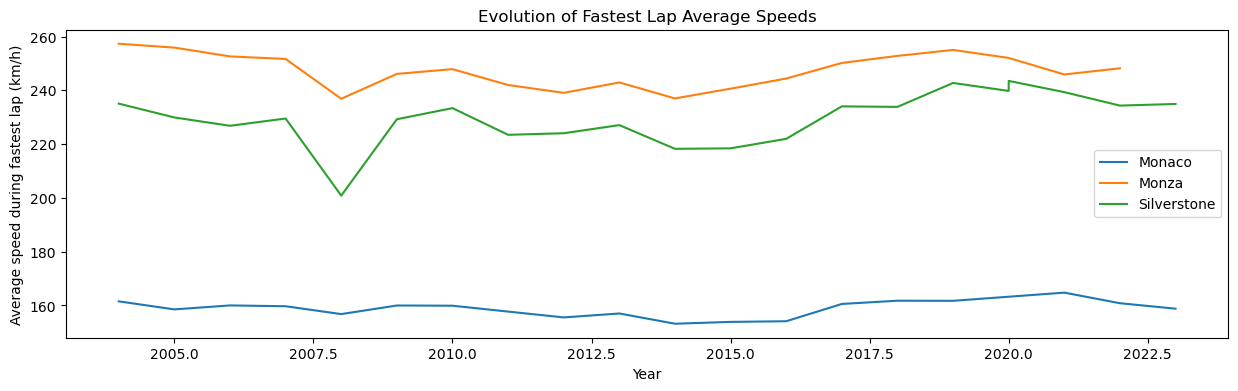

<Figure size 640x480 with 0 Axes>

In [612]:
plt.figure(figsize=(15,4))
plt.plot(fastest_lap_speed_monaco.year,fastest_lap_speed_monaco.fastestLapSpeed, label = "Monaco")
plt.plot(fastest_lap_speed_monza.year,fastest_lap_speed_monza.fastestLapSpeed, label = "Monza")
plt.plot(fastest_lap_speed_silverstone.year,fastest_lap_speed_silverstone.fastestLapSpeed, label = "Silverstone")

plt.legend()
plt.title("Evolution of Fastest Lap Average Speeds")
plt.xlabel("Year")
plt.ylabel("Average speed during fastest lap (km/h)")
plt.show()
plt.clf()

In [604]:
results_races_merged[(results_races_merged.year == 2000) & (results_races_merged.circuitId == 6)]

,raceId,fastestLapSpeed,year,circuitId,name
163,164,NaN,2000,6,Monaco Grand Prix


# Fastest Lap Times

In [605]:
monza_fastest_lap_data_split = monza_fastest_lap_data['lap_time'].str.split(":")
monza_fastest_lap_data["mins"] = monza_fastest_lap_data_split.str.get(0)
monza_fastest_lap_data["secs"] = monza_fastest_lap_data_split.str.get(1)
monza_fastest_lap_data["mins"] = monza_fastest_lap_data["mins"].astype("float")
monza_fastest_lap_data["secs"] = monza_fastest_lap_data["secs"].astype("float")
monza_fastest_lap_data["lap_time"] = 60*monza_fastest_lap_data["mins"] + monza_fastest_lap_data["secs"]
monza_fastest_lap_data = monza_fastest_lap_data[["year", "driver", "lap_time"]]

In [609]:
monaco_fastest_lap_data_split = monaco_fastest_lap_data['lap_time'].str.split(":")
monaco_fastest_lap_data["mins"] = monaco_fastest_lap_data_split.str.get(0)
monaco_fastest_lap_data["secs"] = monaco_fastest_lap_data_split.str.get(1)
monaco_fastest_lap_data["mins"] = monaco_fastest_lap_data["mins"].astype("float")
monaco_fastest_lap_data["secs"] = monaco_fastest_lap_data["secs"].astype("float")
monaco_fastest_lap_data["lap_time"] = 60*monaco_fastest_lap_data["mins"] + monaco_fastest_lap_data["secs"]
monaco_fastest_lap_data = monaco_fastest_lap_data[["year", "driver", "lap_time"]]

In [608]:
silverstone_fastest_lap_data_split = silverstone_fastest_lap_data['lap_time'].str.split(":")
silverstone_fastest_lap_data["mins"] = silverstone_fastest_lap_data_split.str.get(0)
silverstone_fastest_lap_data["secs"] = silverstone_fastest_lap_data_split.str.get(1)
silverstone_fastest_lap_data["mins"] = silverstone_fastest_lap_data["mins"].astype("float")
silverstone_fastest_lap_data["secs"] = silverstone_fastest_lap_data["secs"].astype("float")
silverstone_fastest_lap_data["lap_time"] = 60*silverstone_fastest_lap_data["mins"] + silverstone_fastest_lap_data["secs"]
silverstone_fastest_lap_data = silverstone_fastest_lap_data[["year", "driver", "lap_time"]]

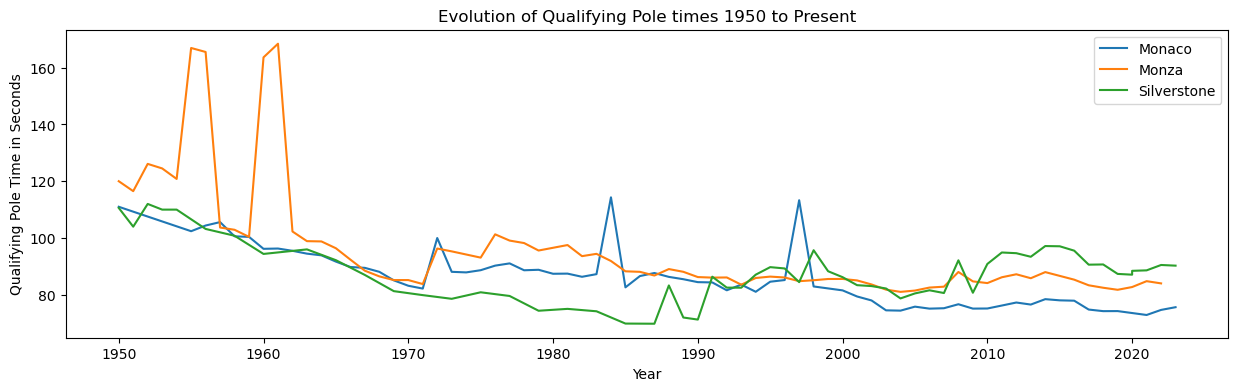

<Figure size 640x480 with 0 Axes>

In [611]:
plt.figure(figsize = (15,4))
plt.plot(monaco_fastest_lap_data.year,monaco_fastest_lap_data.lap_time, label = "Monaco")
plt.plot(monza_fastest_lap_data.year,monza_fastest_lap_data.lap_time, label = "Monza")
plt.plot(silverstone_fastest_lap_data.year,silverstone_fastest_lap_data.lap_time, label = "Silverstone")

plt.legend()
plt.title("Evolution of Fastest times 1950 to Present")
plt.xlabel("Year")
plt.ylabel("Qualifying Pole Time in Seconds")
plt.show()
plt.clf()